In [12]:
import pandas as pd 
import numpy as np
import re
import string
import nltk
from string import digits
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize   
from wordcloud import WordCloud
import matplotlib.pyplot as plt
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Jean Silas\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [6]:
dados = pd.read_csv('train.csv')
dados

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [7]:
x = dados['comment_text']
y = dados[['toxic','severe_toxic','obscene','threat','insult','identity_hate' ]]

In [8]:
stop = set(stopwords.words('english'))

In [9]:
lemmatizer = WordNetLemmatizer()
tokenizador = word_tokenize
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text)
    return [lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text]

Primeiro, bora fazer a analise apenas das palavras. Mais adiante pode ser um 'feature engineering' para compreender correlações entre pontuações, letras maisculas, tamanho da sentença, dentro outros com a toxicidade do comentário

In [13]:
x.drop_duplicates()
def pre_processamento(texto):
    texto=texto.str.translate(str.maketrans(' ', ' ', string.punctuation))
    texto=texto.str.translate(str.maketrans(' ', ' ', '\n'))
    texto=texto.str.translate(str.maketrans(' ', ' ', digits))
    texto=texto.apply(lambda tweet: re.sub(r'([a-z])([A-Z])',r'\1 \2',tweet))
    texto=texto.str.lower()
    texto=texto.str.split()                                                        
    texto=texto.apply(lambda x: [item for item in x if item not in stop])           
    texto = texto.apply(lambda text: lemmatize_words(text))                                                                          #Passando palavras para a forma base
    return texto


In [14]:
dados['comentarios_tratados'] = pre_processamento(x)

## Detalhando funções de pré-processamento
`lower` - Simplismente transforma tudo em letras minúsculas

`translate()` - O método retorna uma string com alguns caracteres substituidos por caracteres descritos em um 'mapping table'. 

Nesse caso essa mapping table é criada com `.maketrans()` que indica nessa ordem: string com caracteres a substituir, string com caracteres substitutos e caracteres a serem removidos.
    
    Source : https://www.w3schools.com/python/ref_string_maketrans.asp
`apply`- Aplica uma funçao ao longo de um eixo no dataframe. Nesse caso estamos usando em uma função `lambda` uma 'expressão recorrente' para a substituição de palavras juntas pelas mesmas separadas.

`lower` - simplismente transforma as letras em minúsculas
`split` - separando a string em palavras separadas com vírgula

`lemmatizewords` objeto criado com a função de transforma as palavras em sua forma base.

WordCloud para checagem da coerência do pré-processamento:

In [17]:
subset=dados[dados.toxic==True]

subset.comentarios_tratados.head()


palavras_toxicas = []

for x in subset.comentarios_tratados.head():
    for y in x:
        palavras_toxicas.append(y)

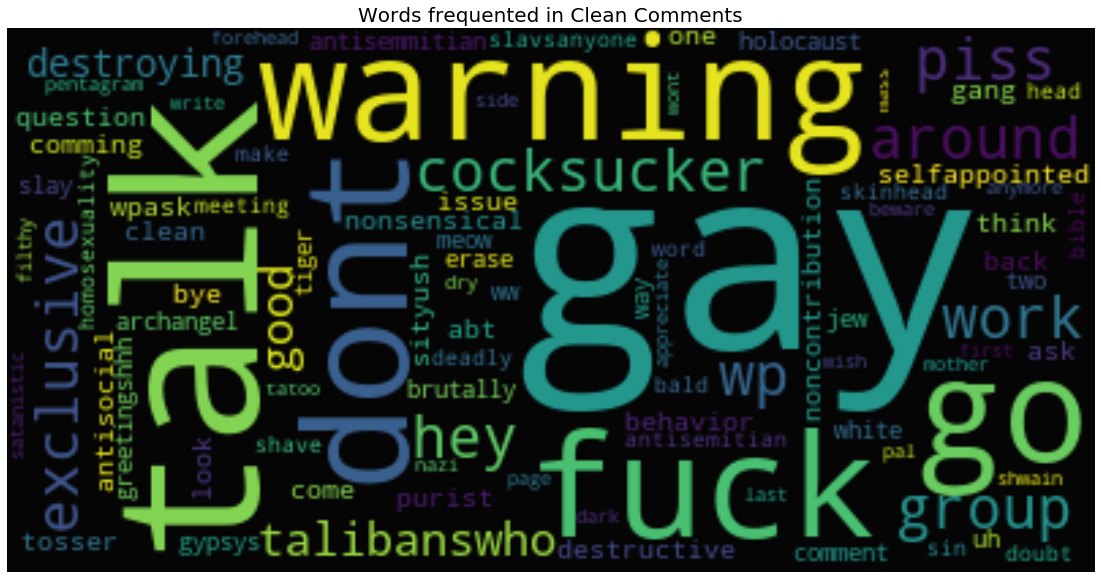

In [18]:

wc= WordCloud(background_color="black",max_words=100)
wc.generate(" ".join(palavras_toxicas))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Words frequented in Clean Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98, interpolation="bilinear")
plt.show()
